# Project #1:
The data folder contains a csv file: penguins_size.csv
- penguins_size.csv: Simplified data from original penguin data sets. Contains variables:
- species: penguin species (Chinstrap, Adélie, or Gentoo)
    - culmen_length_mm: culmen length (mm)
    - culmen_depth_mm: culmen depth (mm)
    - flipper_length_mm: flipper length (mm)
    - body_mass_g: body mass (g)
    - island: island name (Dream, Torgersen, or Biscoe) in the Palmer Archipelago (Antarctica)
    - sex: penguin sex
            
What are culmen length & depth?
    The culmen is "the upper ridge of a bird's beak" (definition from Oxford Languages).

**Task:** 
    Predict the class of penguin species
    
**Questions to Answer:**
- Perform a detailed exploratory data analysis on the dataset
- Experiment using two different ratios of training, validation and test data ie 60-20-20 & 80-10-10. On the two different split ratios do the following
    - Implement Grid Search CV to find optimal hyperparameters for any 3 algorithms (out of LR, SVM, MLP, RF, Boosting)
    - Plot the learning curve using the learning curve function from scikit-learn to analyze the model performance. The plot should show the training score           and cross validation score against the number of training examples.
    - Analyze the results on Validation set and Test set and mention which model performed the best and why?
    - Compare the performance of models(using precision, recall, accuracy, latency).
- What was the best proportion or split ratio of data from the set of experiments you conducted and why?

# Exploratory Data Analysis

- Perform a detailed exploratory data analysis on the dataset

## Read in data

In [1]:
import matplotlib.pyplot as plt
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from time import time
%matplotlib inline

penguins = pd.read_csv('penguins_size.csv')
penguins.head(5)

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


## Exploring the Data

In [2]:
penguins.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


The below table shows the **average** for each of the **continuous features** based on their **species**. The data shows that each of the species have their own specific attributes such as the "culmen_depth_mm" of "Gentoo" is usually around 14.982114 but for the other two species, it is around 18.3-18.4

In [3]:
penguins.groupby('species').mean()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
species,,,,
Adelie,38.791391,18.346358,189.953642,3700.662252
Chinstrap,48.833824,18.420588,195.823529,3733.088235
Gentoo,47.504878,14.982114,217.186992,5076.016260


We can see form the dataframe below that there should be 344 entries for each of the features but there are a few missing values for `culmen_length_mm`, `culmen_depth_mm`, `flipper_length_mm`, `body_mass_g`, and `sex` features that need to be handled.

In [4]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


## Handling missing data

As the `sex` feature is in object form we first have to convert in to numerical values and then handle the missing values. We choose 0 to represent `MALE`, and 1 to represent `FEMALE`. We write back the numeric representation of penguin's sex to the already existing `sex` feature.

In [5]:
gender_num = {'MALE': 0, 'FEMALE': 1}

penguins['sex'] = penguins['sex'].map(gender_num)

As we can see in the below cell, there are a few missing values in the dataset which need to be filled.

In [6]:
missing = penguins.isnull().sum()
missing_percentage = missing*100/len(penguins)
missing_table = pd.concat((missing.rename("# of missing values"), missing_percentage.rename("% of missing values")), axis=1)

missing_table

,# of missing values,% of missing values
species,0,0.000000
island,0,0.000000
culmen_length_mm,2,0.581395
culmen_depth_mm,2,0.581395
flipper_length_mm,2,0.581395
body_mass_g,2,0.581395
sex,11,3.197674


Then we fill all the missing values with the mean value of their respective specie. By doing so, we do not lose any of the data that we currently have.

In [7]:
for i in ['body_mass_g', 'culmen_depth_mm', 'culmen_length_mm', 'flipper_length_mm', 'sex']:
    penguins[i] = penguins[i].fillna(penguins.groupby('species')[i].transform('mean'))
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   344 non-null    float64
 3   culmen_depth_mm    344 non-null    float64
 4   flipper_length_mm  344 non-null    float64
 5   body_mass_g        344 non-null    float64
 6   sex                344 non-null    float64
dtypes: float64(5), object(2)
memory usage: 18.9+ KB


In [8]:
penguins.isnull().sum()

species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

Now that we have handled the missing values of our data, we can continue to the plotting part of our analysis.

## Plotting data

The plots below give us additional insights around the dataset we have. The 4 plots below are the overlaid histograms for `body_mass_g`, `culmen_depth_mm`, `culmen_length_mm`, and `flipper_length_mm`. The histograms show the distribution for different `species` based on their `body_mass_g`, for example. As we can see from the below plots, the `Adelie` and `Chinstrap` attributes overlap in different data and it might be hard for our model to distinct them from one another.

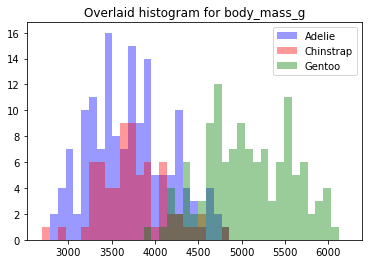

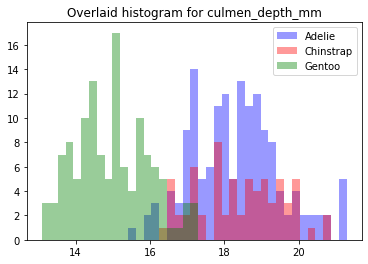

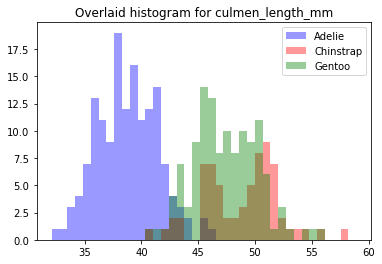

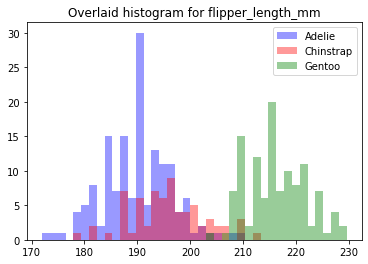

In [9]:
for i in ['body_mass_g', 'culmen_depth_mm', 'culmen_length_mm', 'flipper_length_mm']:
    adelies = list(penguins[penguins['species'] == 'Adelie'][i].dropna())
    chinstraps = list(penguins[penguins['species'] == 'Chinstrap'][i].dropna())
    gentoos = list(penguins[penguins['species'] == 'Gentoo'][i].dropna())
    xmin = min(min(adelies), min(chinstraps), min(gentoos))
    xmax = max(max(adelies), max(chinstraps), max(gentoos))
    width = (xmax - xmin) / 40
    sns.distplot(adelies, color='b', kde=False, bins=np.arange(xmin, xmax, width))
    sns.distplot(chinstraps, color='r', kde=False, bins=np.arange(xmin, xmax, width))
    sns.distplot(gentoos, color='g', kde=False, bins=np.arange(xmin, xmax, width))
    plt.legend(['Adelie', 'Chinstrap', 'Gentoo'])
    plt.title('Overlaid histogram for {}'.format(i))
    plt.show()

Below is a complete plot of, plots of different continuous features of the dataset. As we previously mentioned the `Adelie` and `Chinstrap` attributes overlap most of the time but as we can see from the plots below, for example, `culmen_length_mm` vs `culmen_depth_mm` plot, they are distinctable. Based on the plots below we can say, our model will have a good chance of predicting the species of the penguins correctly.

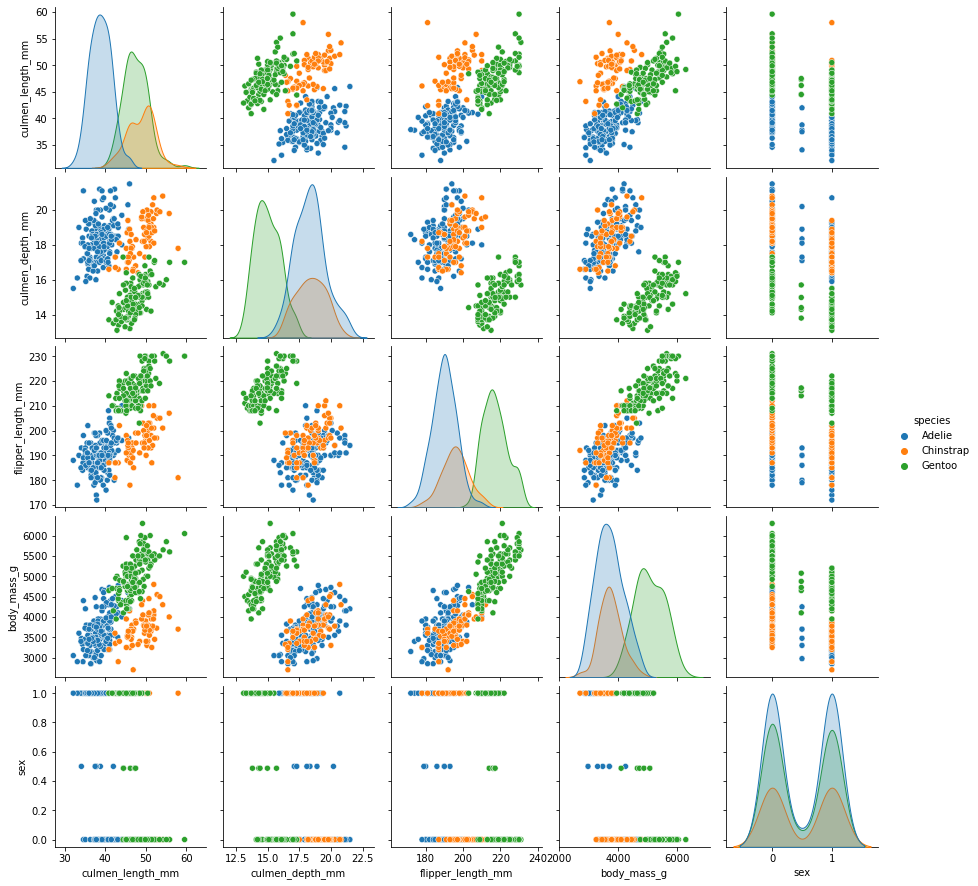

In [10]:
sns.pairplot(penguins.drop('island', axis=1),hue="species")
plt.show()

Below is a plot to show the distribution of `sex` in different `species`. The plot shows our dataset has almost 50/50 distribution between the data we have for `MALE` and `FEMALE` penguins. This gives us an insight that the data is well distributed and the model can learn alot about both of the penguin's sex as it has enough data for each of them. There are a few data that are in the middle which are the result of our missing data handling as we filled them with the mean of sex for their specie.

<AxesSubplot:xlabel='sex', ylabel='count'>

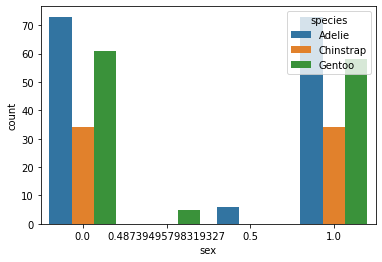

In [11]:
sns.countplot(x="sex", hue="species", data=penguins)

## Cleaning data

`species` and `island` still need to be cleaned before beginning our experiment as the system works well with numbers but not with objects.

In [12]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   344 non-null    float64
 3   culmen_depth_mm    344 non-null    float64
 4   flipper_length_mm  344 non-null    float64
 5   body_mass_g        344 non-null    float64
 6   sex                344 non-null    float64
dtypes: float64(5), object(2)
memory usage: 18.9+ KB


In [13]:
print("Islands unique values: ", penguins['island'].unique())
print("Species unique values: ", penguins['species'].unique())

Islands unique values:  ['Torgersen' 'Biscoe' 'Dream']
Species unique values:  ['Adelie' 'Chinstrap' 'Gentoo']


For the `island` values, We give the values of 0, 1, and 2 to `Torgersen`, `Biscoe`, and `Dream` respectively. Also, for the `species` values, We give the values of 0, 1, and 2 to `Adelie`, `Chinstrap`, and `Gentoo` respectively.

In [14]:
island_num = {'Torgersen' : 0, 'Biscoe' : 1, 'Dream' : 2}
species_num = {'Adelie' : 0, 'Chinstrap' : 1, 'Gentoo' : 2}

penguins['island'] = penguins['island'].map(island_num)
penguins['species'] = penguins['species'].map(species_num)
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    int64  
 1   island             344 non-null    int64  
 2   culmen_length_mm   344 non-null    float64
 3   culmen_depth_mm    344 non-null    float64
 4   flipper_length_mm  344 non-null    float64
 5   body_mass_g        344 non-null    float64
 6   sex                344 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 18.9 KB


# Experiment

- Experiment using two different ratios of training, validation and test data ie 60-20-20 & 80-10-10. On the two different split ratios do the following
    - Implement Grid Search CV to find optimal hyperparameters for any 3 algorithms (out of LR, SVM, MLP, RF, Boosting)
    - Plot the learning curve using the learning curve function from scikit-learn to analyze the model performance. The plot should show the training score           and cross validation score against the number of training examples.
    - Analyze the results on Validation set and Test set and mention which model performed the best and why?
    - Compare the performance of models(using precision, recall, accuracy, latency).

In [15]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    int64  
 1   island             344 non-null    int64  
 2   culmen_length_mm   344 non-null    float64
 3   culmen_depth_mm    344 non-null    float64
 4   flipper_length_mm  344 non-null    float64
 5   body_mass_g        344 non-null    float64
 6   sex                344 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 18.9 KB


## Data splitting

First we need to split the data. We split the data by 2 different ratios between the training, validation, and test data to find the better performing ratio. The ratios for train-val-test are 60-20-20 and 80-10-10.

In [16]:
features = penguins.drop('species', axis=1)
labels = penguins['species']

# 60-20-20 ratio
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(features, labels, test_size=0.4, random_state=42)
X_test_1, X_val_1, y_test_1, y_val_1 = train_test_split(X_test_1, y_test_1, test_size=0.5, random_state=42)

# 80-10-10 ratio
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(features, labels, test_size=0.2, random_state=42)
X_test_2, X_val_2, y_test_2, y_val_2 = train_test_split(X_test_2, y_test_2, test_size=0.5, random_state=42)

print("First ratio: ")
for dataset in [y_train_1, y_val_1, y_test_1]:
    print(round(len(dataset) / len(labels), 2))
    
print("\nSecond ratio: ")
for dataset in [y_train_2, y_val_2, y_test_2]:
    print(round(len(dataset) / len(labels), 2))

"""
X_train_1.to_csv('1_train_features.csv', index=False)
X_val_1.to_csv('1_val_features.csv', index=False)
X_test_1.to_csv('1_test_features.csv', index=False)

y_train_1.to_csv('1_train_labels.csv', index=False)
y_val_1.to_csv('1_val_labels.csv', index=False)
y_test_1.to_csv('1_test_labels.csv', index=False)

X_train_2.to_csv('2_train_features.csv', index=False)
X_val_2.to_csv('2_val_features.csv', index=False)
X_test_2.to_csv('2_test_features.csv', index=False)

y_train_2.to_csv('2_train_labels.csv', index=False)
y_val_2.to_csv('2_val_labels.csv', index=False)
y_test_2.to_csv('2_test_labels.csv', index=False)
"""

First ratio: 
0.6
0.2
0.2

Second ratio: 
0.8
0.1
0.1


"\nX_train_1.to_csv('1_train_features.csv', index=False)\nX_val_1.to_csv('1_val_features.csv', index=False)\nX_test_1.to_csv('1_test_features.csv', index=False)\n\ny_train_1.to_csv('1_train_labels.csv', index=False)\ny_val_1.to_csv('1_val_labels.csv', index=False)\ny_test_1.to_csv('1_test_labels.csv', index=False)\n\nX_train_2.to_csv('2_train_features.csv', index=False)\nX_val_2.to_csv('2_val_features.csv', index=False)\nX_test_2.to_csv('2_test_features.csv', index=False)\n\ny_train_2.to_csv('2_train_labels.csv', index=False)\ny_val_2.to_csv('2_val_labels.csv', index=False)\ny_test_2.to_csv('2_test_labels.csv', index=False)\n"

## Finding Optimal Hyperparameters for LR, SVM, MLP, RF, and GB

We chose Logistic Regression, Support Vector Machines, Multilayer Perceptron, Random Forest, and Gradient Boosting algorihtms to find the best performing model on this prediction task. To have a good prediction model we need to first find its optimal hyperparameters and then compare their performance. We use `GridSearchCV` by `scikit` library to tune our hyperparameters which tries different parameters to get the best working parameters and train our model with those parameters. We also use `print_results` function to print out the results for our trials in `GridSearchCV`. We also `dump` our models by using `joblib` library so that when we want to compare our models, it would be easier for us to extract them.

In [17]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

#### Logistic Regression Hyperparameter Tuning

In [18]:
lr = LogisticRegression()
parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

cv = GridSearchCV(lr, parameters, cv=5)
cv1 = cv.fit(X_train_1, y_train_1.values.ravel())
cv2 = cv.fit(X_train_2, y_train_2.values.ravel())
print("GridSearchCV results for Logistic Regression model on trainset #1: ")
print_results(cv1)
print("\n\nGridSearchCV results for Logistic Regression model on trainset #2: ")
print_results(cv2)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

GridSearchCV results for Logistic Regression model on trainset #1: 
BEST PARAMS: {'C': 0.01}

0.884 (+/-0.063) for {'C': 0.001}
0.982 (+/-0.023) for {'C': 0.01}
0.978 (+/-0.015) for {'C': 0.1}
0.982 (+/-0.023) for {'C': 1}
0.978 (+/-0.015) for {'C': 10}
0.971 (+/-0.044) for {'C': 100}
0.971 (+/-0.029) for {'C': 1000}


GridSearchCV results for Logistic Regression model on trainset #2: 
BEST PARAMS: {'C': 0.01}

0.884 (+/-0.063) for {'C': 0.001}
0.982 (+/-0.023) for {'C': 0.01}
0.978 (+/-0.015) for {'C': 0.1}
0.982 (+/-0.023) for {'C': 1}
0.978 (+/-0.015) for {'C': 10}
0.971 (+/-0.044) for {'C': 100}
0.971 (+/-0.029) for {'C': 1000}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [19]:
print("Best LR model for trainset #1: ", cv1.best_estimator_)
print("Best LR model for trainset #2: ", cv2.best_estimator_)
joblib.dump(cv1.best_estimator_, 'LR_model_1.pkl')
joblib.dump(cv2.best_estimator_, 'LR_model_2.pkl')

Best LR model for trainset #1:  LogisticRegression(C=0.01)
Best LR model for trainset #2:  LogisticRegression(C=0.01)


['LR_model_2.pkl']

#### Support Vector Machines Hyperparameter Tuning

In [20]:
svc = SVC()
parameters = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10]
}

cv = GridSearchCV(svc, parameters, cv=5)
svc1 = cv.fit(X_train_1, y_train_1.values.ravel())
svc2 = cv.fit(X_train_2, y_train_2.values.ravel())
print("GridSearchCV results for Suppport Vector Machines model on trainset #1: ")
print_results(svc1)
print("\n\nGridSearchCV results for Suppport Vector Machines model on trainset #2: ")
print_results(svc2)

GridSearchCV results for Suppport Vector Machines model on trainset #1: 
BEST PARAMS: {'C': 1, 'kernel': 'linear'}

0.993 (+/-0.018) for {'C': 0.1, 'kernel': 'linear'}
0.749 (+/-0.063) for {'C': 0.1, 'kernel': 'rbf'}
0.996 (+/-0.015) for {'C': 1, 'kernel': 'linear'}
0.753 (+/-0.067) for {'C': 1, 'kernel': 'rbf'}
0.993 (+/-0.029) for {'C': 10, 'kernel': 'linear'}
0.756 (+/-0.054) for {'C': 10, 'kernel': 'rbf'}


GridSearchCV results for Suppport Vector Machines model on trainset #2: 
BEST PARAMS: {'C': 1, 'kernel': 'linear'}

0.993 (+/-0.018) for {'C': 0.1, 'kernel': 'linear'}
0.749 (+/-0.063) for {'C': 0.1, 'kernel': 'rbf'}
0.996 (+/-0.015) for {'C': 1, 'kernel': 'linear'}
0.753 (+/-0.067) for {'C': 1, 'kernel': 'rbf'}
0.993 (+/-0.029) for {'C': 10, 'kernel': 'linear'}
0.756 (+/-0.054) for {'C': 10, 'kernel': 'rbf'}


In [21]:
print("Best SVM model for trainset #1: ", svc1.best_estimator_)
print("Best SVM model for trainset #2: ", svc2.best_estimator_)
joblib.dump(svc1.best_estimator_, 'SVM_model_1.pkl')
joblib.dump(svc2.best_estimator_, 'SVM_model_2.pkl')

Best SVM model for trainset #1:  SVC(C=1, kernel='linear')
Best SVM model for trainset #2:  SVC(C=1, kernel='linear')


['SVM_model_2.pkl']

#### Multilayer Perceptron Hyperparameter Tuning

In [22]:
mlp = MLPClassifier()
parameters = {
    'hidden_layer_sizes': [(10,), (50,), (100,)],
    'activation': ['relu', 'tanh', 'logistic'],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

cv = GridSearchCV(mlp, parameters, cv=5)
mlp1 = cv.fit(X_train_1, y_train_1.values.ravel())
mlp2 = cv.fit(X_train_2, y_train_2.values.ravel())
print("GridSearchCV results for Multilayer Perceptron model on trainset #1: ")
print_results(mlp1)
print("\n\nGridSearchCV results for Multilayer Perceptron model on trainset #2: ")
print_results(mlp2)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multi

GridSearchCV results for Multilayer Perceptron model on trainset #1: 
BEST PARAMS: {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive'}

0.269 (+/-0.185) for {'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate': 'constant'}
0.342 (+/-0.217) for {'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate': 'invscaling'}
0.364 (+/-0.174) for {'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive'}
0.455 (+/-0.21) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'constant'}
0.324 (+/-0.417) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling'}
0.4 (+/-0.436) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive'}
0.513 (+/-0.34) for {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}
0.505 (+/-0.201) for {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling'}
0.487 (+/-0.11

In [23]:
print("Best mlp model for trainset #1: ", mlp1.best_estimator_)
print("Best mlp model for trainset #2: ", mlp2.best_estimator_)
joblib.dump(mlp1.best_estimator_, 'MLP_model_1.pkl')
joblib.dump(mlp2.best_estimator_, 'MLP_model_2.pkl')

Best mlp model for trainset #1:  MLPClassifier(activation='tanh', learning_rate='adaptive')
Best mlp model for trainset #2:  MLPClassifier(activation='tanh', learning_rate='adaptive')


['MLP_model_2.pkl']

#### Random Forest Hyperparameter Tuning

In [24]:
rf = RandomForestClassifier()
parameters = {
    'n_estimators': [5, 50, 250],
    'max_depth': [2, 4, 8, 16, 32, None]
}

cv = GridSearchCV(rf, parameters, cv=5)
rf1 = cv.fit(X_train_1, y_train_1.values.ravel())
rf2 = cv.fit(X_train_2, y_train_2.values.ravel())
print("GridSearchCV results for Random Forest model on trainset #1: ")
print_results(rf1)
print("\n\nGridSearchCV results for Random Forest model on trainset #2: ")
print_results(rf2)

GridSearchCV results for Random Forest model on trainset #1: 
BEST PARAMS: {'max_depth': 8, 'n_estimators': 50}

0.924 (+/-0.093) for {'max_depth': 2, 'n_estimators': 5}
0.971 (+/-0.029) for {'max_depth': 2, 'n_estimators': 50}
0.971 (+/-0.018) for {'max_depth': 2, 'n_estimators': 250}
0.967 (+/-0.027) for {'max_depth': 4, 'n_estimators': 5}
0.978 (+/-0.027) for {'max_depth': 4, 'n_estimators': 50}
0.982 (+/-0.023) for {'max_depth': 4, 'n_estimators': 250}
0.982 (+/-0.033) for {'max_depth': 8, 'n_estimators': 5}
0.985 (+/-0.027) for {'max_depth': 8, 'n_estimators': 50}
0.985 (+/-0.027) for {'max_depth': 8, 'n_estimators': 250}
0.956 (+/-0.029) for {'max_depth': 16, 'n_estimators': 5}
0.985 (+/-0.027) for {'max_depth': 16, 'n_estimators': 50}
0.985 (+/-0.027) for {'max_depth': 16, 'n_estimators': 250}
0.975 (+/-0.037) for {'max_depth': 32, 'n_estimators': 5}
0.985 (+/-0.027) for {'max_depth': 32, 'n_estimators': 50}
0.985 (+/-0.027) for {'max_depth': 32, 'n_estimators': 250}
0.985 (+/-0

In [25]:
print("Best rf model for trainset #1: ", rf1.best_estimator_)
print("Best rf model for trainset #2: ", rf2.best_estimator_)
joblib.dump(rf1.best_estimator_, 'RF_model_1.pkl')
joblib.dump(rf2.best_estimator_, 'RF_model_2.pkl')

Best rf model for trainset #1:  RandomForestClassifier(max_depth=8, n_estimators=50)
Best rf model for trainset #2:  RandomForestClassifier(max_depth=8, n_estimators=50)


['RF_model_2.pkl']

#### Gradient Boosing Hyperparameter Tuning

In [26]:
gb = GradientBoostingClassifier()
parameters = {
    'n_estimators': [5, 50, 250, 500],
    'max_depth': [1, 3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 1, 10, 100]
}

cv = GridSearchCV(gb, parameters, cv=5)
gb1 = cv.fit(X_train_1, y_train_1.values.ravel())
gb2 = cv.fit(X_train_2, y_train_2.values.ravel())
print("GridSearchCV results for Gradient Boosing model on trainset #1: ")
print_results(gb1)
print("\n\nGridSearchCV results for Gradient Boosing model on trainset #2: ")
print_results(gb2)

GridSearchCV results for Gradient Boosing model on trainset #1: 
BEST PARAMS: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 250}

0.436 (+/-0.0) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 5}
0.942 (+/-0.042) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 50}
0.96 (+/-0.042) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 250}
0.967 (+/-0.027) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 500}
0.436 (+/-0.0) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 5}
0.978 (+/-0.027) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
0.975 (+/-0.018) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250}
0.975 (+/-0.018) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
0.436 (+/-0.0) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 5}
0.982 (+/-0.023) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}
0.982 (+/-0.023) for {'learning_rate': 0.01, 'max_depth':

In [27]:
print("Best gb model for trainset #1: ", gb1.best_estimator_)
print("Best gb model for trainset #2: ", gb2.best_estimator_)
joblib.dump(gb1.best_estimator_, 'GB_model_1.pkl')
joblib.dump(gb2.best_estimator_, 'GB_model_2.pkl')

Best gb model for trainset #1:  GradientBoostingClassifier(max_depth=1, n_estimators=250)
Best gb model for trainset #2:  GradientBoostingClassifier(max_depth=1, n_estimators=250)


['GB_model_2.pkl']

## Learning Curves

To plot the learning curves we first need to extract the models we dumped and then plot the models.

In [28]:
models1= {}
models2 = {}

for mdl in ['LR', 'SVM', 'MLP', 'RF', 'GB']:
    models1[mdl] = joblib.load('{}_model_1.pkl'.format(mdl))
    models2[mdl] = joblib.load('{}_model_2.pkl'.format(mdl))

print("Our tuned hyperparameters for the trainset of 60-20-20 split between the train-validation-test sets: \n")
for mdl in models1:
    print("   {} : {}".format(mdl, models1[mdl]))
    
print("\n\nOur tuned hyperparameters for the trainset of 80-10-10 split between the train-validation-test sets: \n")
for mdl in models2:
    print("   {} : {}".format(mdl, models2[mdl]))

Our tuned hyperparameters for the trainset of 60-20-20 split between the train-validation-test sets: 

   LR : LogisticRegression(C=0.01)
   SVM : SVC(C=1, kernel='linear')
   MLP : MLPClassifier(activation='tanh', learning_rate='adaptive')
   RF : RandomForestClassifier(max_depth=8, n_estimators=50)
   GB : GradientBoostingClassifier(max_depth=1, n_estimators=250)


Our tuned hyperparameters for the trainset of 80-10-10 split between the train-validation-test sets: 

   LR : LogisticRegression(C=0.01)
   SVM : SVC(C=1, kernel='linear')
   MLP : MLPClassifier(activation='tanh', learning_rate='adaptive')
   RF : RandomForestClassifier(max_depth=8, n_estimators=50)
   GB : GradientBoostingClassifier(max_depth=1, n_estimators=250)


We use the `plot_learning_curve` function to plot our learning curves. This function is taken from scikit-learn website and is accessible via [this link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py). Learning curves show the relationship between training set size and our chosen evaluation metric which can helpful when we are diagnosing our models of overfitting and underfitting.

In [29]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

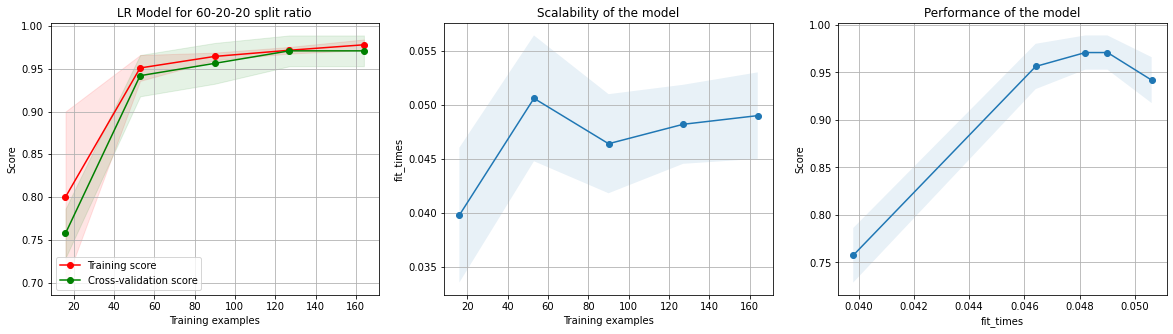

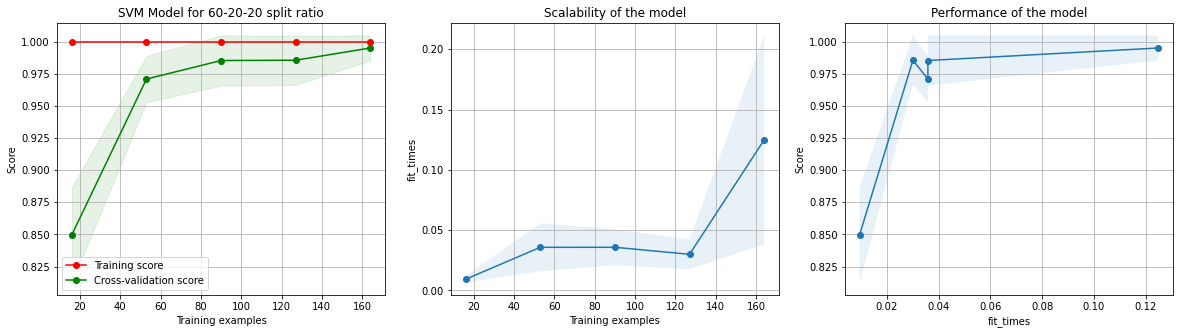

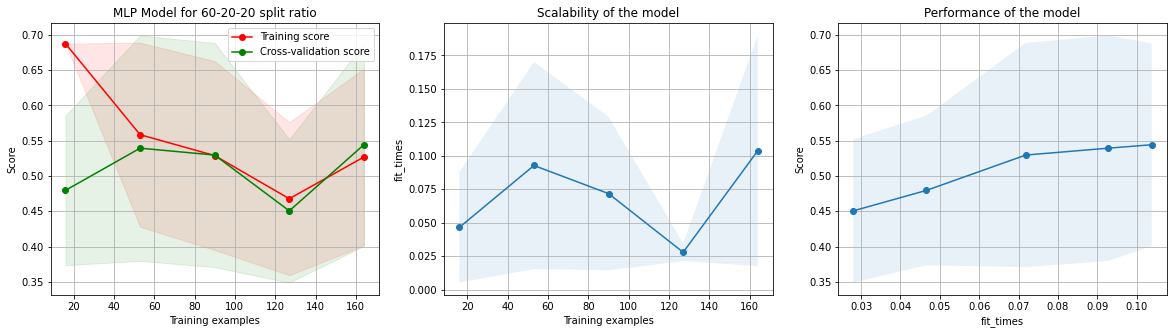

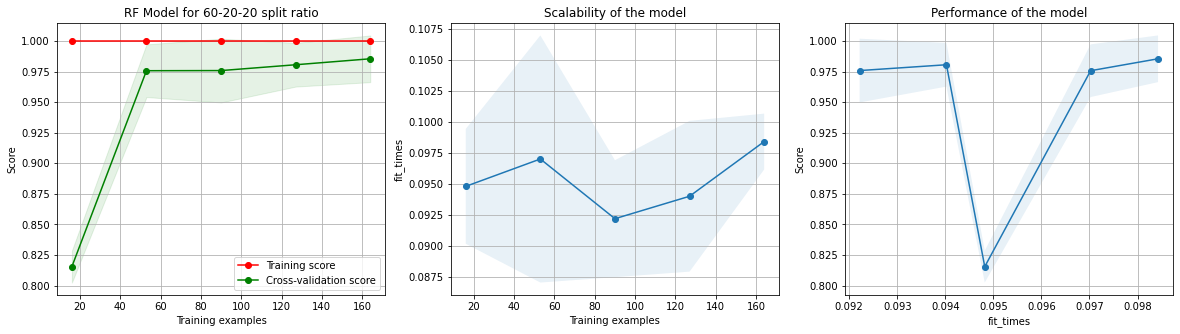

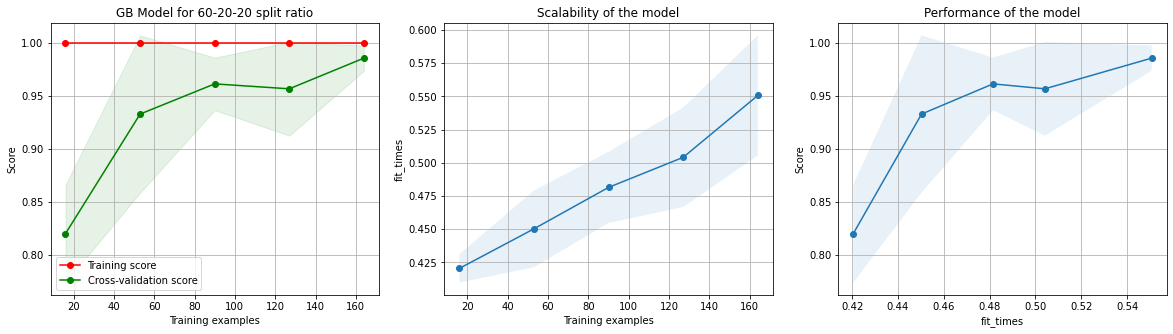

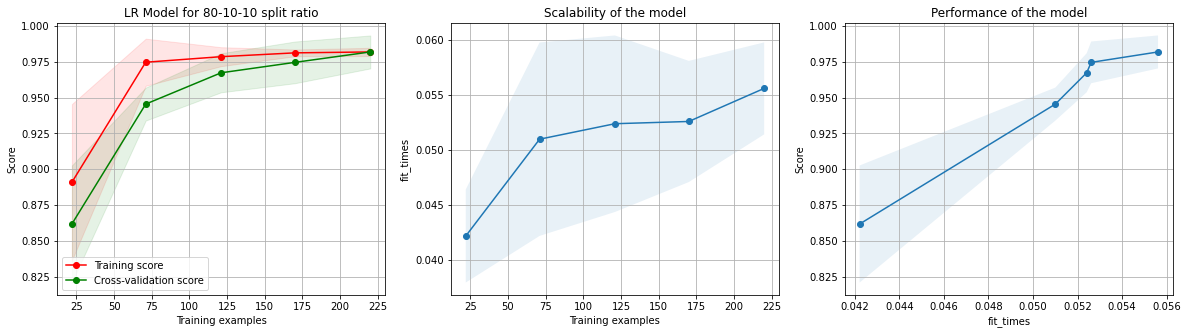

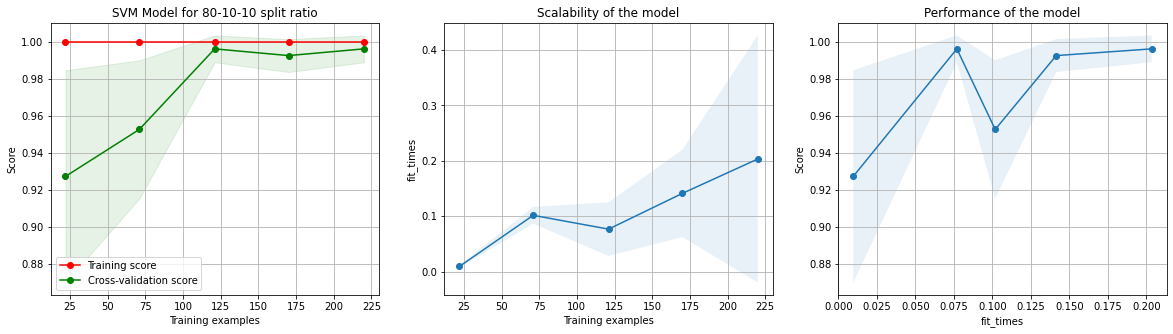

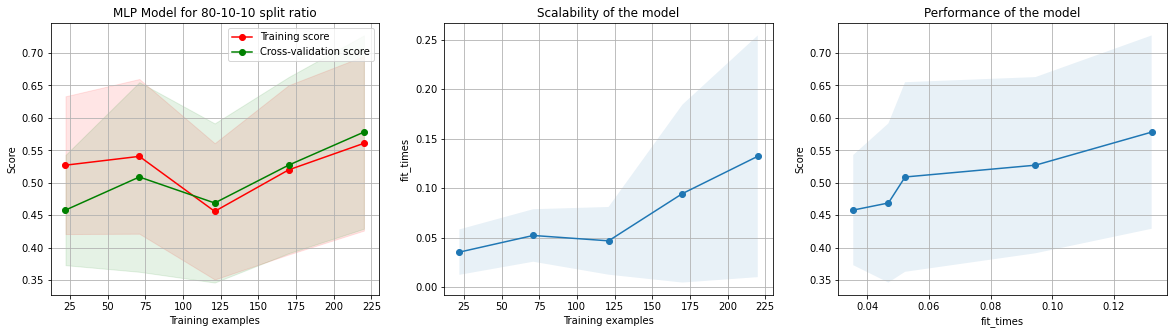

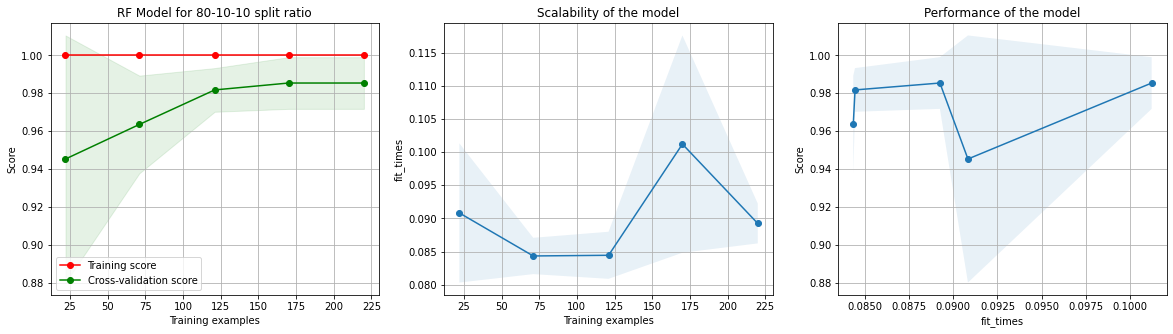

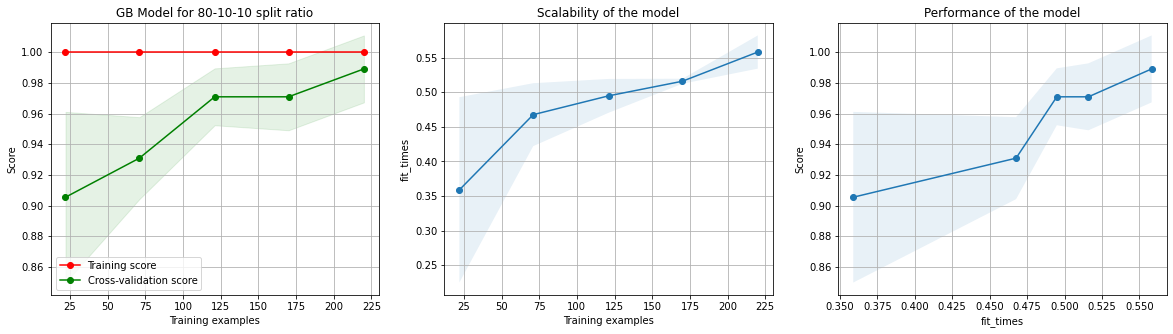

In [30]:
for mdl, params in models1.items():
    plot_learning_curve(params, "{} Model for 60-20-20 split ratio".format(mdl), X_train_1, y_train_1, cv=5)


for mdl, params in models2.items():
    plot_learning_curve(params, "{} Model for 80-10-10 split ratio".format(mdl), X_train_2, y_train_2, cv=5)

## Model Comparison

We already have our models from the beginning of `Learning Curves` section where we extracted the dumped models into `models1` and `models2`. We use the following function, `evaluate_model`, to evaluate our models and compare them based on it. This function prints the `Accuracy`, `Precision`, and `Recall` scores for a model and gives its `Latency` as well.

In [31]:
def evaluate_model(name, model, features, labels):
    start = time()
    pred = model.predict(features)
    end = time()
    accuracy = round(accuracy_score(labels, pred), 3)
    precision = round(precision_score(labels, pred, average="macro"), 3)
    recall = round(recall_score(labels, pred, average="macro"), 3)
    
    print('{} -- Accuracy: {} / Precision: {} / Recall: {} / Latency: {}ms'.format(name,
                                                                                   accuracy,
                                                                                   precision,
                                                                                   recall,
                                                                                   round((end - start)*1000, 1)))

We run all of our models on the validation and test dataset to find the best performing model.

In [32]:
print("Results for running trained models (using first trainset) on validation set: ")
for name, mdl in models1.items():
    evaluate_model(name, mdl, X_val_1, y_val_1)

print("\n\nResults for running trained models (using second trainset) on validation set: ")
for name, mdl in models2.items():
    evaluate_model(name, mdl, X_val_2, y_val_2)
    
print("\n\nResults for running trained models (using first trainset) on test set: ")
for name, mdl in models1.items():
    evaluate_model(name, mdl, X_test_1, y_test_1)

print("\n\nResults for running trained models (using second trainset) on test set: ")
for name, mdl in models2.items():
    evaluate_model(name, mdl, X_test_2, y_test_2)

Results for running trained models (using first trainset) on validation set: 
LR -- Accuracy: 0.986 / Precision: 0.987 / Recall: 0.99 / Latency: 2.0ms
SVM -- Accuracy: 0.986 / Precision: 0.99 / Recall: 0.972 / Latency: 2.0ms
MLP -- Accuracy: 0.725 / Precision: 0.484 / Recall: 0.594 / Latency: 3.0ms
RF -- Accuracy: 1.0 / Precision: 1.0 / Recall: 1.0 / Latency: 12.0ms
GB -- Accuracy: 0.986 / Precision: 0.99 / Recall: 0.972 / Latency: 4.0ms


Results for running trained models (using second trainset) on validation set: 
LR -- Accuracy: 1.0 / Precision: 1.0 / Recall: 1.0 / Latency: 2.0ms
SVM -- Accuracy: 1.0 / Precision: 1.0 / Recall: 1.0 / Latency: 2.0ms
MLP -- Accuracy: 0.714 / Precision: 0.476 / Recall: 0.566 / Latency: 2.0ms
RF -- Accuracy: 1.0 / Precision: 1.0 / Recall: 1.0 / Latency: 11.0ms
GB -- Accuracy: 1.0 / Precision: 1.0 / Recall: 1.0 / Latency: 3.0ms


Results for running trained models (using first trainset) on test set: 
LR -- Accuracy: 0.971 / Precision: 0.977 / Recall: 0.9

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedM

As we can see the best performing model is `Random Forest` model which gives us the highest `Accuracy`, `Precision`, and `Recall` scores among validation/test set and the 2 different proportions of data we have. The reasons behind that are:
- Our dataset is not large enough to perform better with the other models
- The relationships between the data are not complex
- The prediction time is not important for us

Our models' scores had surprisingly the same order for each of the accuracy, precision, and recall, so instead of comparing each score for every model, I decided to merge the accuracy, precision, and recall scores and compare the models totally for these three scores.

Comparing the models based on their performance scores:
- **_Accuracy_**, **_Precision_**, **_Recall_**: Random Forest model performed the best in terms of accuracy, precision, and recall. Following RF, Gradient Boosting and Support Vector Machines performed similarly based on their scores and also the Logistic Regression model had almost the same scores but a little bit lower. Lastly, the Multilayer Perceptron model had the worst scores with a significant difference. `RF` > `GB` = `SVM` > `LR` >> `MLP`
- **_Latency_**: In terms of latency the Logistic Regression, Support Vector Machines, and Multilayer Perceptron models are the fastests among the models we have and they change their positions interchangebly when we run the models a few times. After them, the Gradient Boosting has the lowest latency which is up by just 1.0ms maximum. At last, the Random Forest model is the slowest model which has significantly higher latency. `LR` = `SVM` = `MLP` < `GB` << `RF`

# Conclusion

- What was the best proportion or split ratio of data from the set of experiments you conducted and why?

From the experiment, we found that for both split ratios, 60-20-20 and 80-10-10, models chosen were the same, which means we got the same parameters for 60-20-20 proportion, as we got for 80-10-10 proportion of our dataset but 60-20-20 is better since it has a better distribution of data and gives us the chance to pick the better model as it has more data in validation dataset. Also the 60-20-20 split ratio did better in predicting for the test dataset and hence the best split ratio is 60-20-20 for the `penguins_size` dataset.